In [1]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims

/tmp/ipykernel_18275/1448159700.py:8: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_18275/1448159700.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:

device = "cuda"
print("loading model")
model = HookedTransformer.from_pretrained(
    "gpt2-xl",
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=False,
    refactor_factored_attn_matrices=True,
    device=device,
)
# model.to(device)
print("done")
model.set_use_attn_result(True)
model.cfg.total_heads = model.cfg.n_heads * model.cfg.n_layers

model.reset_hooks()

loading model


Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
done


In [3]:
from utils.dataset_utils import MS_Dataset, Elem_Dataset, MisCons_Dataset, Kinder_Dataset, HS_Dataset, BoolQ_Question_Dataset, TruthfulQA_Tfn, CounterFact_Tfn, Fever_Tfn, BoolQ_Tfn, Creak_Tfn, CommonClaim_Tfn
random_seed = 5

datanames = ["MS", "Elem", "MisCons", "Kinder", "HS", "TruthfulQA", "CounterFact", "Fever", "Creak", "BoolQ", "CommonClaim"]

ms_data = MS_Dataset(model.tokenizer, questions=True)
elem_data = Elem_Dataset(model.tokenizer, questions=True)
miscons_data = MisCons_Dataset(model.tokenizer, questions=True)
kinder_data = Kinder_Dataset(model.tokenizer, questions=True)
hs_data = HS_Dataset(model.tokenizer, questions=True)
# boolq_data = BoolQ_Question_Dataset(model.tokenizer)

tqa_data = TruthfulQA_Tfn(model.tokenizer, questions=True)
cfact_data = CounterFact_Tfn(model.tokenizer, questions=True)
fever_data = Fever_Tfn(model.tokenizer, questions=True)
boolq_data = BoolQ_Tfn(model.tokenizer, questions=True)
creak_data = Creak_Tfn(model.tokenizer, questions=True)
commonclaim_data = CommonClaim_Tfn(model.tokenizer, questions=True)

datasets = {"MS": ms_data, "Elem": elem_data, "MisCons": miscons_data, "Kinder": kinder_data, "HS": hs_data, "TruthfulQA": tqa_data, "CounterFact": cfact_data, "Fever": fever_data, "Creak": creak_data, "BoolQ": boolq_data, "CommonClaim": commonclaim_data}

# datanames = datanames[:4]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--elem_tf-64ec49cd4cd5be64/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--ms_tf-728c6138d8f6c1c5/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--misconceptions_tf-131f43b181040ffa/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--kindergarten_tf-e3c53e366bc35ec1/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--hs_tf-9f911d9357ff2386/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset parquet (/root/.cache/huggingface/datasets/notrichardren___parquet/notrichardren--truthfulness-4380c84abeab6c8f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
n_acts = 1000
acts = {}

for name in datanames:
    # acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre", "logits"])
    acts[name] = ModelActs(model, datasets[name], act_types=["z", "logits"])
    model_acts: ModelActs = acts[name]
    # model_acts.gen_acts(N=n_acts, id=f"{name}_gpt2xl_{n_acts}")
    model_acts.load_acts(id=f"{name}_gpt2xl_{n_acts}", load_probes=False)
    model_acts.train_probes("z", max_iter=1000)

torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [01:41<00:00, 11.77it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [01:07<00:00, 17.84it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:51<00:00, 23.22it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:43<00:00, 27.47it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:55<00:00, 21.63it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [01:19<00:00, 15.02it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [01:25<00:00, 14.02it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [01:08<00:00, 17.49it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [01:03<00:00, 18.84it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:20<00:00, 58.70it/s]


torch.Size([800, 1200, 64]), torch.Size([200, 1200, 64]), torch.Size([800, 1200]), torch.Size([200, 1200])


100%|██████████| 1200/1200 [00:39<00:00, 30.14it/s]


In [5]:
from utils.interp_utils import tot_logit_diff
check_balanced_output = False
for name in datanames:
    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, acts[name], use_probs=True, test_only=True, check_balanced_output=check_balanced_output)
    if check_balanced_output:
        print(f"{name}, positive responses are {positive_sum.mean()}, negative responses are {negative_sum.mean()}, {(positive_sum.mean() - negative_sum.mean())*100}%")
    else:
        print(f"{name}, correct responses are {positive_sum.mean()}, incorrect responses are {negative_sum.mean()}, {(positive_sum.mean() - negative_sum.mean())*100}%")


proportion of positive labels is 0.545
MS, correct responses are 0.18501269817352295, incorrect responses are 0.17993199825286865, 0.5080699920654297%
proportion of positive labels is 0.525
Elem, correct responses are 0.1996905654668808, incorrect responses are 0.18849939107894897, 1.1191174983978271%
proportion of positive labels is 0.47
MisCons, correct responses are 0.19432184100151062, incorrect responses are 0.18227098882198334, 1.205085277557373%
proportion of positive labels is 0.5
Kinder, correct responses are 0.20363649725914001, incorrect responses are 0.18752188980579376, 1.6114606857299805%


In [6]:
sum(datasets["TruthfulQA"].sample(100)[2])

50

In [13]:
from utils.iti_utils import patch_iti
n_acts = 1000

iti_acts = {}
for name in datanames:
    # iti_acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre","logits"])
    iti_acts[name] = ModelActs(model, datasets[name], act_types=["z", "logits"])
    cache_interventions = torch.zeros(size=(model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head))
    patch_iti(model, acts[name], topk=50, alpha=20, use_MMD=True, model_device="cuda", cache_interventions=cache_interventions, train_only=True)
    model_acts: ModelActs = iti_acts[name]

    # if name == "BoolQ":
    # model_acts.gen_acts(N=n_acts, id=f"iti_{name}_gpt2xl_{n_acts}", indices=acts[name].indices)
    # else:
    model_acts.load_acts(id=f"iti_{name}_gpt2xl_{n_acts}", load_probes=False)
    # model_acts.train_probes("z", max_iter=1000)
    model_acts.indices_trains = acts[name].indices_trains
    model_acts.indices_tests = acts[name].indices_tests

    print(cache_interventions.sum())

tensor(391., device='cuda:0')
tensor(-83.9176)
tensor(395., device='cuda:0')
tensor(-8.2439)
tensor(406., device='cuda:0')
tensor(91.5392)
tensor(400., device='cuda:0')
tensor(-36.0229)


In [8]:
from utils.interp_utils import tot_logit_diff
print("After ITI:")
check_balanced_output = True
for name in datanames:
    positive_sum, negative_sum = tot_logit_diff(model.tokenizer, iti_acts[name], use_probs=True, test_only=True, check_balanced_output=check_balanced_output)
    if check_balanced_output:
        print(f"{name}, positive responses are {positive_sum.mean()}, negative responses are {negative_sum.mean()}, {(positive_sum.mean() - negative_sum.mean())*100}%")
    else:
        print(f"{name}, correct responses are {positive_sum.mean()}, incorrect responses are {negative_sum.mean()}, {(positive_sum.mean() - negative_sum.mean())*100}%")


After ITI:
proportion of positive labels is 0.545
MS, positive responses are 0.047782983630895615, negative responses are 0.011726857163012028, 3.6056127548217773%
proportion of positive labels is 0.525
Elem, positive responses are 0.009867622517049313, negative responses are 0.004172171466052532, 0.5695450901985168%
proportion of positive labels is 0.47
MisCons, positive responses are 0.2763483226299286, negative responses are 0.14349928498268127, 13.284903526306152%
proportion of positive labels is 0.5
Kinder, positive responses are 0.042433127760887146, negative responses are 0.0047070360742509365, 3.772609233856201%


In [9]:
model.reset_hooks()
from utils.dataset_utils import test_model_output
# print(test_model_output(model, input_str='Is the below statement true or false? Snakes are not vertebrates. Answer:'))

dataset_indices = range(20, 25)
for name in datanames:
    # iti_acts[name] = ModelActs(model, datasets[name], act_types=["z", "mlp_out", "resid_post", "resid_pre","logits"])
    cache_interventions = torch.zeros(size=(model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head))

    print(f"Before ITI, on {name}:")
    model.reset_hooks()
    [print(x) for x in test_model_output(model, dataset=elem_data, temperature=0, max_length=10, dataset_indices=dataset_indices)]
    patch_iti(model, acts[name], topk=50, alpha=20, use_MMD=True, model_device="cuda", cache_interventions=cache_interventions, train_only=True)
    print(f"After ITI:")
    [print(x) for x in test_model_output(model, dataset=elem_data, temperature=0, max_length=10, dataset_indices=dataset_indices)]
    print("\n\n\n")

Before ITI, on MS:
Is the below statement true or false? Sharks are not fish. Answer: False

The above statement is true.

Is the below statement true or false? Snails are not animals, they are plants. Answer: Snails are animals. Snails are plants.
Is the below statement true or false? All animals are capable of feeling emotions. Answer: True

False

Question: What is
Is the below statement true or false? Wolves are social animals that live in packs. Answer: False. Wolves are solitary animals that live in packs
Is the below statement true or false? Elephants are afraid of mice. Answer: False. Elephants are not afraid of mice
After ITI:
Is the below statement true or false? Sharks are not fish. Answer: The following is not a legal matter and is not
Is the below statement true or false? Snails are not animals, they are plants. Answer: Snails are plants. Snails are plants.
Is the below statement true or false? All animals are capable of feeling emotions. Answer: All animals are capable of

proportion of positive labels is 0.545
proportion of positive labels is 0.525
proportion of positive labels is 0.47
proportion of positive labels is 0.5
proportion of positive labels is 0.545
proportion of positive labels is 0.525
proportion of positive labels is 0.47
proportion of positive labels is 0.5


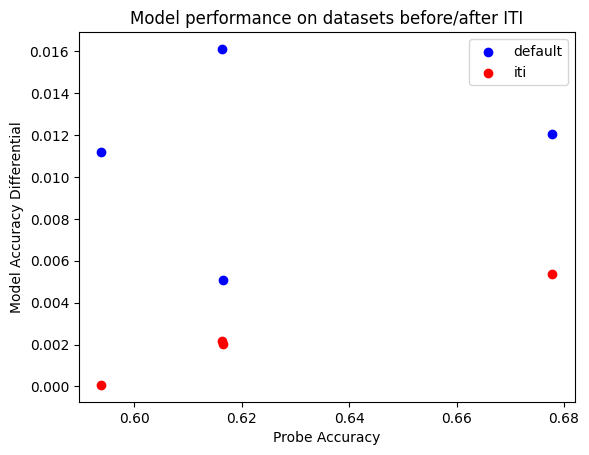

{'MS': 0.616, 'Elem': 0.594, 'MisCons': 0.678, 'Kinder': 0.616}


In [9]:
# plot graph of model accuracy differential vs probe accuracy
import matplotlib.pyplot as plt

colors=['b', 'r']
names=["default", "iti"]
probe_acc_dict = {}
for idx, act_list in enumerate([acts, iti_acts]):
    model_acc_diffs = []
    probe_accs = []
    for name in datanames:
        positive_sum, negative_sum = tot_logit_diff(model.tokenizer, act_list[name], use_probs=True, check_balanced_output=False)
        model_acc_diffs.append(positive_sum.mean() - negative_sum.mean())

        probe_accs.append(acts[name].probe_accs["z"].mean())
        probe_acc_dict[name] = round(acts[name].probe_accs["z"].mean(), 3)

    plt.scatter(probe_accs, model_acc_diffs, c=colors[idx], label=names[idx])

plt.title("Model performance on datasets before/after ITI")
plt.xlabel("Probe Accuracy")
plt.ylabel("Model Accuracy Differential")
plt.legend()
plt.show()

print(probe_acc_dict)

## Plot more datapoints 
Plot above graph with more datasets, probe accuracies at different percentiles (100, 90, 80, etc).
We want a detailed graph showing model inference accuracy vs probe accuracy

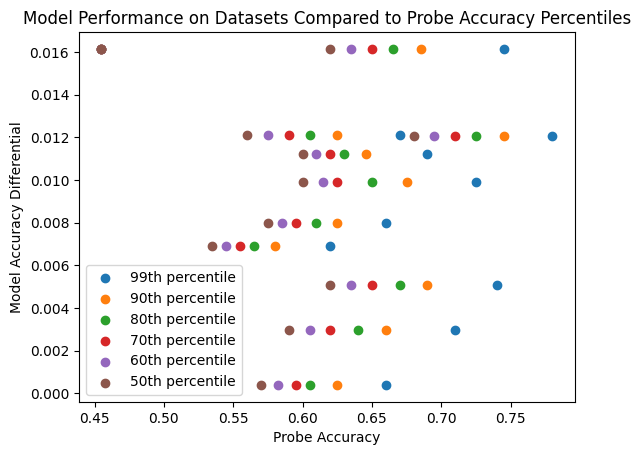

{'MS': 0.62, 'Elem': 0.6, 'MisCons': 0.68, 'Kinder': 0.62, 'HS': 0.575, 'TruthfulQA': 0.59, 'CounterFact': 0.535, 'Fever': 0.6, 'Creak': 0.56, 'BoolQ': 0.455, 'CommonClaim': 0.57}


In [7]:
# plot graph of model accuracy differential vs probe accuracy
import matplotlib.pyplot as plt
from utils.interp_utils import tot_logit_diff

# colors = ['b', 'r']
names = [f'{x}th percentile' for x in [99, 90, 80, 70, 60, 50]]
probe_acc_dict = {}
for idx, percentile in enumerate([99, 90, 80, 70, 60, 50]):
    model_acc_diffs = []
    probe_accs = []
    for name in datanames:
        positive_sum, negative_sum = tot_logit_diff(model.tokenizer, acts[name], use_probs=True, check_balanced_output=False)
        model_acc_diffs.append(positive_sum.mean() - negative_sum.mean())

        probe_accs.append(np.percentile(acts[name].probe_accs["z"], percentile))
        probe_acc_dict[name] = round(np.percentile(acts[name].probe_accs["z"], percentile), 3)

    plt.scatter(probe_accs, model_acc_diffs, label=names[idx])

plt.title("Model Performance on Datasets Compared to Probe Accuracy Percentiles")
plt.xlabel("Probe Accuracy")
plt.ylabel("Model Accuracy Differential")
plt.legend()
plt.show()

print(probe_acc_dict)